In [1]:
from pymatgen.io.vasp import Xdatcar, Structure, Lattice
from pymatgen_diffusion.aimd.van_hove import RadialDistributionFunction
from polyhedral_analysis.polyhedra_recipe import create_matching_site_generator

import yaml
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from functools import partial

import version_information
from tqdm import tqdm_notebook

In [2]:
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Minion Pro']
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams.update({'font.size': 18})
rcParams['mathtext.fontset'] = 'dejavuserif'

In [3]:
def flatten_list( this_list ):
    return [ item for sublist in this_list for item in sublist ]

In [4]:
# 48h-48h separation in `Li6PS5Cl_Neutron.cif` is 1.959 Angstroms.

In [5]:
# Create reference structures containing ideal 24g sites in 2x2x2 supercells.

s24g = Structure.from_file( '../../data/reference_structures/Li6PS5Cl_Neutron.cif' )
s24g.remove_species([ 'S', 'I', 'P', 'Li'])
s24g.make_supercell([2,2,2])

# Create reference structures containing ideal 48h sites in 2x2x2 supercells.
s48h = Structure.from_file( '../../data/reference_structures/Li6PS5I_Neutron_new_48h.cif' )
s48h.remove_species([ 'S', 'I', 'P', 'Mg'])
s48h.make_supercell([2,2,2])


# s48hCl = Structure.from_file( '../../data/reference_structures/Li6PS5Cl_Neutron.cif' )
# s48hCl.remove_species([ 'S', 'I', 'P'])
# s48hCl.make_supercell([2,2,2])

# # Create reference structures containing "new" 48h sites in 2x2x2 supercells.

s48h_new = Structure.from_file( '../../data/reference_structures/Li6PS5I_Neutron_supplemented.cif' )
s48h_new.remove_species([ 'S', 'I', 'P', 'Li'])
s48h_new.make_supercell([2,2,2])

In [6]:
def all_distances_to_sites( structures, ref_structures, species, show_progress=False ):
    """
    Collect the minimum distances between ion positions in a series of structures
    and the sites in a set of reference structures.
    
    Args:
        structures (list(`pymatgen.Structure`)): List of pymatgen Structure objects, e.g. from a MD run.
        ref_structures (list`pymatgen.Structure`): List of pymatgen Structure, containing only the reference sites.
        species (str): Species string for which atoms to analyse from the input Structure objects.
        
    Returns:
        (list(float)): List of distances in Angstroms.
    """
    distance = [ [] for i in ref_structures ]
    if show_progress:
        progress = partial(tqdm_notebook, leave=False)
    else:
        progress = lambda x: x
    for struc in progress(structures):
        all_dr = np.array([ distances_to_sites( struc, ref_structure, species ) 
                           for ref_structure in ref_structures ])
        for dr in all_dr.T:
            distance[np.argmin(dr)].append(min(dr))
    return distance

In [7]:
def distances_to_sites( structure, ref_structure, species):
    atoms = [ s for s in structure if s.species_string == species]
    lattice = structure.lattice
    ref_site_coords = np.array( [ s.frac_coords for s in ref_structure] )
    atom_coords = np.array( [ a.frac_coords for a in atoms ] )
    dist_matrix = lattice.get_all_distances(ref_site_coords, atom_coords)
    site_list_indices = np.argmin(dist_matrix, axis=0)
    dr = []
    for atom, site_list_index in zip( atoms, site_list_indices ):
        dr.append(lattice.get_distance_and_image(atom.frac_coords, ref_structure[site_list_index].frac_coords)[0])
    return np.array(dr)

In [8]:
with open('../md_runs.yaml', 'r') as f:
    md_runs = yaml.load(f)
print(md_runs)

{'Li6PS5I': {'0p': [1, 2, 3, 4], '50p': [1, 2, 3, 4, 5], '100p': [1, 2, 3, 4]}, 'Li6PS5Cl': {'0p': [1, 2, 3, 4], '50p': [1, 2, 3, 4], '100p': [1, 2, 3, 4]}}


In [9]:
system = 'Li6PS5I'
disorder = '0p'
runs = [1,2,3,4]
distance_data = {}
data_dir = '../../data/'
for system in md_runs:
    distance_data[system] = {}
    for disorder, runs in md_runs[system].items():
        distance_data[system][disorder] = {}
        for ia in ['inherent', 'actual']:
            print(f'{system} {disorder} {ia}')
            distance_data[system][disorder][ia] = {}
            xdatcar_filenames = [ f'{data_dir}/{system}/{disorder}/run{i}/{ia}_XDATCAR.gz' for i in runs ]
            xdatcars = ( Xdatcar( f ) for f in xdatcar_filenames )
            structures = flatten_list( [ x.structures for x in xdatcars ] )
            distance_data[system][disorder][ia]['48h'] = all_distances_to_sites( 
                structures, [ s48h ], 'Li', show_progress=True )[0]

Li6PS5I 0p inherent


Li6PS5I 0p actual


Li6PS5I 50p inherent


Li6PS5I 50p actual


Li6PS5I 100p inherent


Li6PS5I 100p actual


Li6PS5Cl 0p inherent


Li6PS5Cl 0p actual


Li6PS5Cl 50p inherent


Li6PS5Cl 50p actual


Li6PS5Cl 100p inherent


Li6PS5Cl 100p actual


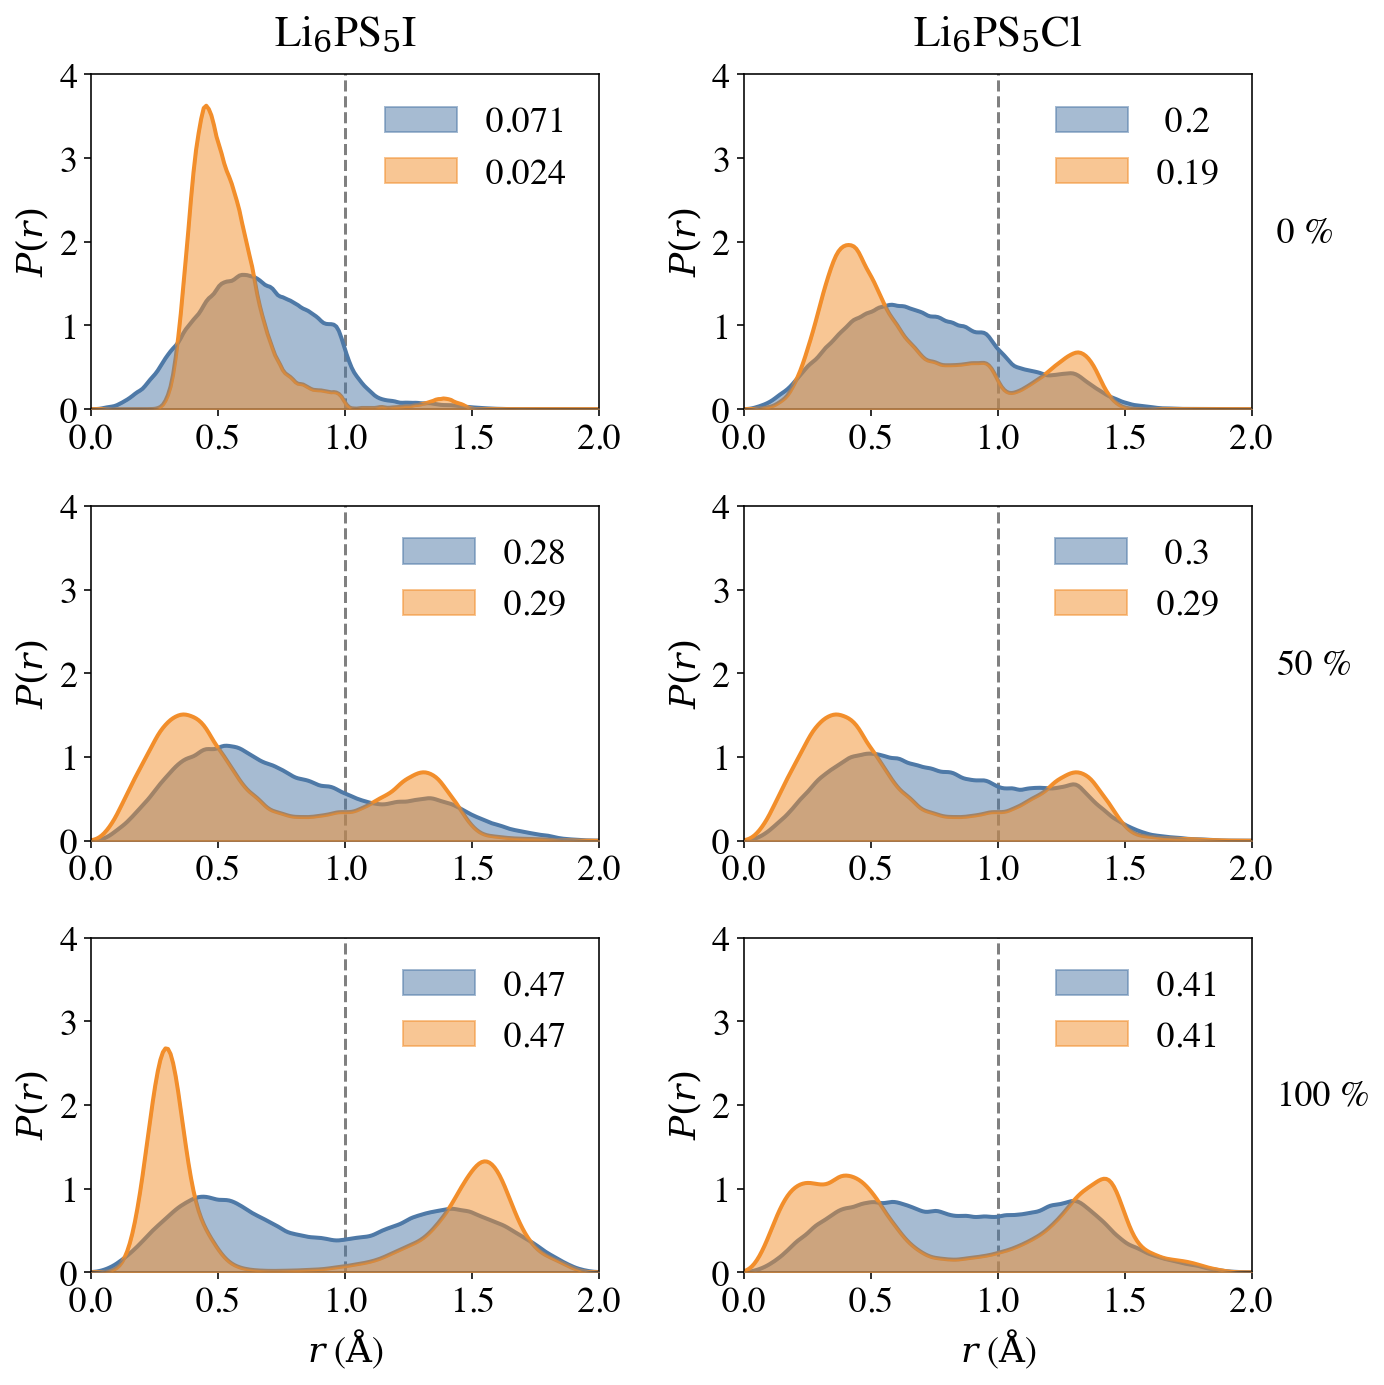

In [16]:
from scipy.stats import gaussian_kde

cutoff = 1.0
color = {'inherent': '#f28e2b',
         'actual': '#4e79a7'}

fig, ax = plt.subplots(3,2,figsize=(10,10))

def plot_distances(axes, distances, label=None, color=None, linestyle=None):
    kde = gaussian_kde(distances, bw_method=0.05)
    xs = np.linspace(0.0,2.0,200)
    ys = kde(xs)
    l = axes.plot(xs, ys, antialiased=True, linewidth=2, color=color)
    l = axes.fill_between(xs, ys, alpha=.5, zorder=5, antialiased=True, color=color, label=label)
    axes.legend(fancybox=False, loc='upper right', frameon=False)
    
def fraction_outside_cutoff(distances, cutoff):
    return len(np.where(distances>cutoff)[0])/len(distances)
    

distances = np.array(distance_data['Li6PS5I']['0p']['actual']['48h'])
plot_distances(ax[0,0], distances, label=f'{fraction_outside_cutoff(distances, cutoff):4.2}', 
               color=color['actual'], linestyle='-')
distances = np.array(distance_data['Li6PS5I']['0p']['inherent']['48h'])
plot_distances(ax[0,0], distances, label=f'{fraction_outside_cutoff(distances, cutoff):4.2}', 
               color=color['inherent'], linestyle='--')

distances = np.array(distance_data['Li6PS5I']['50p']['actual']['48h'])
plot_distances(ax[1,0], distances, label=f'{fraction_outside_cutoff(distances, cutoff):4.2}', 
               color=color['actual'], linestyle='-')
distances = np.array(distance_data['Li6PS5Cl']['50p']['inherent']['48h'])
plot_distances(ax[1,0], distances, label=f'{fraction_outside_cutoff(distances, cutoff):4.2}', 
               color=color['inherent'], linestyle='--')

distances = np.array(distance_data['Li6PS5I']['100p']['actual']['48h'])
plot_distances(ax[2,0], distances, label=f'{fraction_outside_cutoff(distances, cutoff):4.2}', 
               color=color['actual'], linestyle='-')
distances = np.array(distance_data['Li6PS5I']['100p']['inherent']['48h'])
plot_distances(ax[2,0], distances, label=f'{fraction_outside_cutoff(distances, cutoff):4.2}', 
               color=color['inherent'], linestyle='--')


distances = np.array(distance_data['Li6PS5Cl']['0p']['actual']['48h'])
plot_distances(ax[0,1], distances, label=f'{fraction_outside_cutoff(distances, cutoff):4.2}', 
               color=color['actual'], linestyle='-')
distances = np.array(distance_data['Li6PS5Cl']['0p']['inherent']['48h'])
plot_distances(ax[0,1], distances, label=f'{fraction_outside_cutoff(distances, cutoff):4.2}', 
               color=color['inherent'], linestyle='--')

distances = np.array(distance_data['Li6PS5Cl']['50p']['actual']['48h'])
plot_distances(ax[1,1], distances, label=f'{fraction_outside_cutoff(distances, cutoff):4.2}', 
               color=color['actual'], linestyle='-')
distances = np.array(distance_data['Li6PS5Cl']['50p']['inherent']['48h'])
plot_distances(ax[1,1], distances, label=f'{fraction_outside_cutoff(distances, cutoff):4.2}', 
               color=color['inherent'], linestyle='--')

distances = np.array(distance_data['Li6PS5Cl']['100p']['actual']['48h'])
plot_distances(ax[2,1], distances, label=f'{fraction_outside_cutoff(distances, cutoff):4.2}', 
               color=color['actual'], linestyle='-')
distances = np.array(distance_data['Li6PS5Cl']['100p']['inherent']['48h'])
plot_distances(ax[2,1], distances, label=f'{fraction_outside_cutoff(distances, cutoff):4.2}', 
               color=color['inherent'], linestyle='--')

for i in range(3):
    for j in range(2):
        ax[i,j].vlines(1.0, 0.0, 5.0, linestyle='--', color='grey')
        ax[i,j].set_ylim([0.0,4.0])
        ax[i,j].set_xlim([0.0,2.0])
        
xlabel = r'$r$ ($\mathrm{\AA}$)'
ylabel = r'$P(r)$'
ax[0,0].set_title(r'Li$_6$PS$_5$I', pad=15)
ax[0,1].set_title(r'Li$_6$PS$_5$Cl', pad=15)
ax[2,0].set(xlabel=xlabel, ylabel=ylabel)
ax[1,0].set(ylabel=ylabel)
ax[0,0].set(ylabel=ylabel)
ax[1,1].set(ylabel=ylabel)
ax[0,1].set(ylabel=ylabel)
ax[2,1].set(xlabel=xlabel, ylabel=ylabel)

ax[0,1].text(2.1,2.0,'0 %')
ax[1,1].text(2.1,2.0,'50 %')
ax[2,1].text(2.1,2.0,'100 %')
        
plt.tight_layout()
plt.savefig('../../figures/spherical_site_analysis.pdf')
plt.show()